In [54]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gprofiler import GProfiler

In [55]:
gp = GProfiler(return_dataframe=True)
organism_id = 'mmusculus'

In [3]:
#load in the infected tissue subset with only infected or bystander cells - no control cells
adata = sc.read_h5ad('infected_cells_DE.h5ad')
print(f"Cell types: {adata.obs['cell_type'].value_counts()}")
print(f"Condition: {adata.obs['condition'].value_counts()}")
print(f"Infected status: {adata.obs['infected_status'].value_counts()}")
# Check if there's bacterial contact info
print(f"\nAvailable columns with 'kp' or 'bacterial': {[col for col in adata.obs.columns if 'kp' in col.lower() or 'bacterial' in col.lower()]}")

Cell types: cell_type
IM    832
AM    776
Name: count, dtype: int64
Condition: condition
KP+    810
KP-    798
Name: count, dtype: int64
Infected status: infected_status
Infected    1608
Name: count, dtype: int64

Available columns with 'kp' or 'bacterial': []


Pseudotime analysis can help you FIND the STAT6 gene sets.

  Here's the logic:

  Current problem: Your broad IM/AM bacterial vs bystander comparisons show no STAT6 signatures - they're dominated
   by classical antimicrobial responses.

  Pseudotime solution:
  1. Run pseudotime first - This will order cells along infection progression trajectories
  2. Find branch points - Look for cells that diverge from the main antimicrobial trajectory
  3. Identify late-stage cells - These might represent the M(Kp)/STAT6 polarized state
  4. Test these specific cell populations - Run pathway analysis on genes expressed in the terminal branches

  The paper likely found that some infected cells progress along a different trajectory than others, leading to
  STAT6 activation. Your current broad groupings mix early-stage and late-stage infected cells together, masking
  the STAT6 signature.

  Workflow:
  1. Pseudotime analysis → identifies cell trajectories
  2. Branch analysis → finds divergent cell populations

In [4]:
# Basic processing for pseudotime
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [5]:
#Scale and PCA
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
sc.tl.umap(adata)

/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


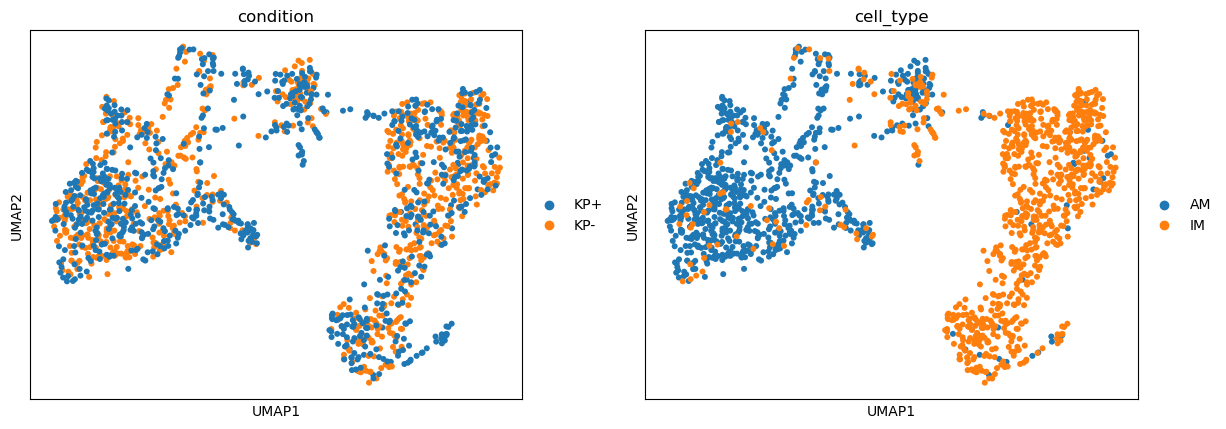

In [6]:
# Plot to see current distribution
sc.pl.umap(adata, color=['condition', 'cell_type'], ncols=2)

Since there is no transition between the two distinct cell types, we will do the trajectory analysis seperately:

In [7]:
# Split by cell type
am_cells = adata[adata.obs['cell_type'] == 'AM'].copy()
im_cells = adata[adata.obs['cell_type'] == 'IM'].copy()

In [8]:
print(f"AM cells: {am_cells.n_obs}")
print(f"IM cells: {im_cells.n_obs}")
print(f"AM condition: {am_cells.obs['condition'].value_counts()}")
print(f"IM condition: {im_cells.obs['condition'].value_counts()}")

AM cells: 776
IM cells: 832
AM condition: condition
KP+    395
KP-    381
Name: count, dtype: int64
IM condition: condition
KP-    417
KP+    415
Name: count, dtype: int64


#### Starting with IM cells:

In [9]:
 # Reprocess IM cells for trajectory analysis
sc.pp.highly_variable_genes(im_cells, min_mean=0.0125, max_mean=3, min_disp=0.5)
im_cells.raw = im_cells
im_cells = im_cells[:, im_cells.var.highly_variable]

/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:305: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


In [10]:
sc.pp.scale(im_cells, max_value=10)
sc.tl.pca(im_cells, svd_solver='arpack')
sc.pp.neighbors(im_cells, n_neighbors=15, n_pcs=40)
sc.tl.umap(im_cells)

/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
# Try multiple resolutions on IM cells
sc.tl.leiden(im_cells, resolution=0.1, key_added='leiden_0.1')
sc.tl.leiden(im_cells, resolution=0.3, key_added='leiden_0.3')
sc.tl.leiden(im_cells, resolution=0.5, key_added='leiden_0.5')
sc.tl.leiden(im_cells, resolution=0.8, key_added='leiden_0.8')
sc.tl.leiden(im_cells, resolution=1, key_added='leiden_1.0')
sc.tl.leiden(im_cells, resolution=1.2, key_added='leiden_1.2')

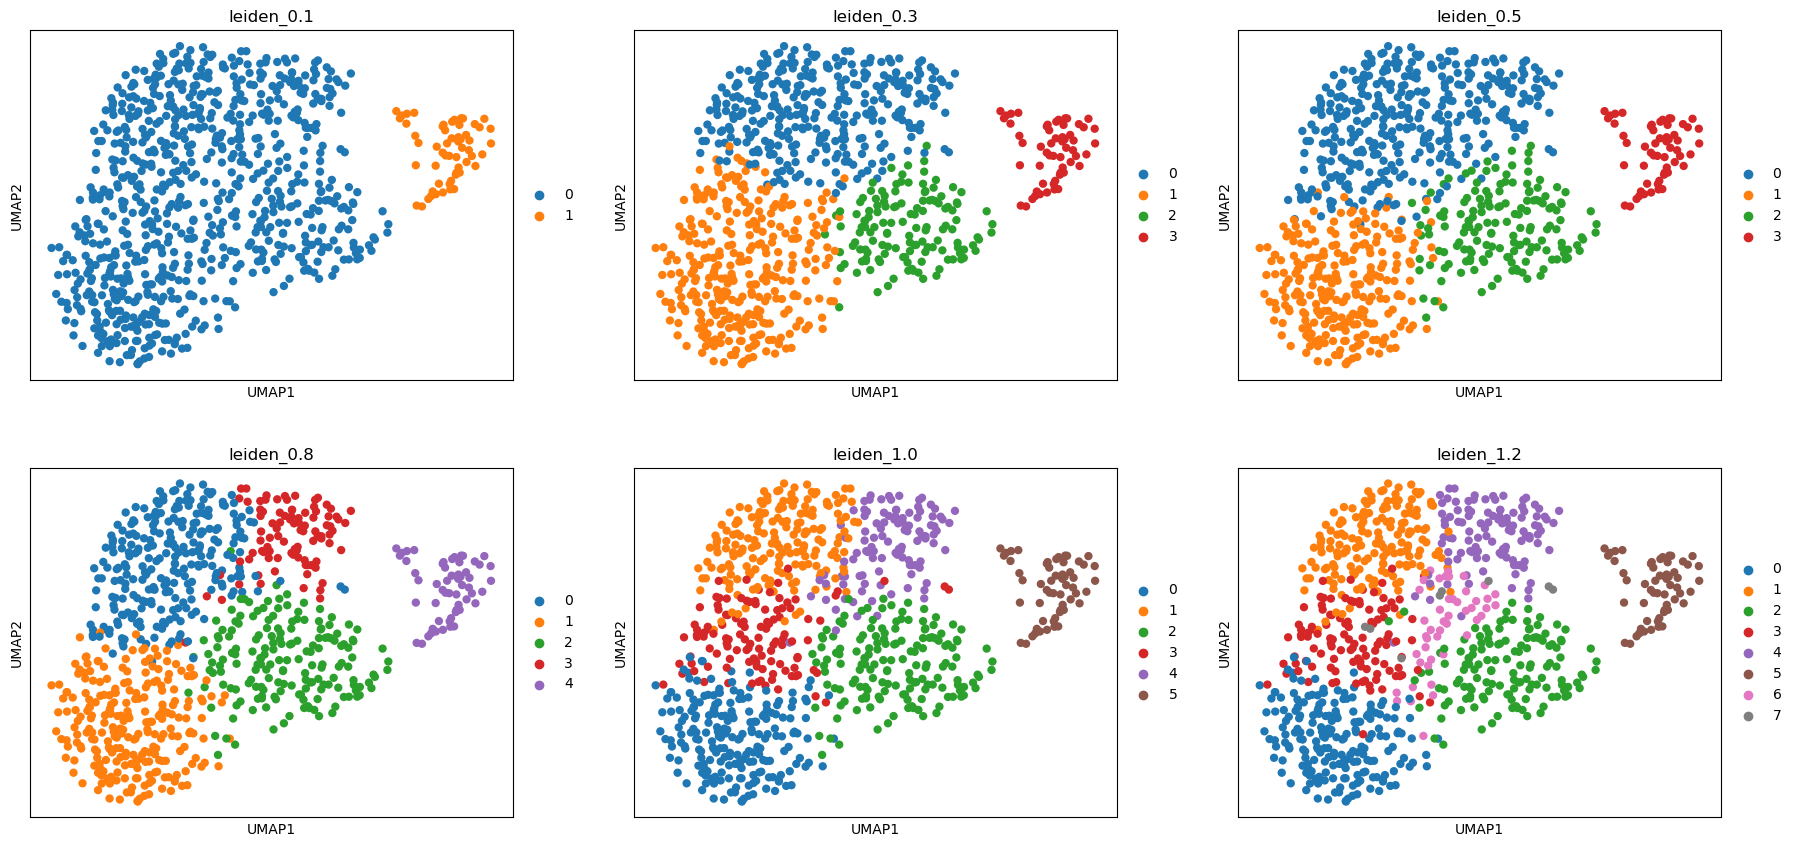

In [19]:
sc.pl.umap(im_cells, color=['leiden_0.1', 'leiden_0.3', 'leiden_0.5', 'leiden_0.8','leiden_1.0','leiden_1.2'], ncols=3)

<h3> Partition Tuning and PAGA Preparation: </h3>
Look for a resolution where KP- and KP+ cells are reasonably separated but not over-fragmented. Usually 0.3-0.5
works well for trajectory analysis. Ideally, the resolution shows just a bit of overlap between the clusters, not hard boundaries.

<b> HOWEVER - higher resolutions are better when: </b>
<b> 1. Multiple Response Pathways </b>

- If IM cells have different activation programs (e.g., classical vs. alternative activation)
- If there are distinct inflammatory vs. tissue repair responses
- If some cells undergo apoptosis while others proliferate

<b> 2. Temporal Heterogeneity </b>

- If bacterial contact triggers sequential waves of gene expression
- If early-response genes vs. late-response genes define distinct states
- If there are "checkpoint" states where cells pause before full activation

<b> 3. Branching Trajectories </b>

- If some cells become pro-inflammatory while others become <b> immunosuppressive/anti-inflammatory</b>
- If there are multiple terminal fates beyond just "activated"
- If bystander cells themselves split into multiple response types

Thus, we continue with <b> 0.8 </b> resolution, anticipating that the observed permissiveness of IM to KP is an immunosuppressive of some cells, as the main reaction of macrophages is certainly pro-inflammatory (immune-postive)

<h4>To help interpret the PAGA and logically/quantitatively deduce the order of pseudotime states, we look at the crosstabs of the generated clusters.</h4>

 The cluster distribution crosstab tells you:

  <b> Good resolution indicators: </b>
  - Mixed clusters - Some clusters have both KP+ and KP- cells (transition states)
  - Pure terminal clusters - Some clusters are mostly KP+ only (potential M(Kp) end states)
  - Clear starting point - In our data, we actually start with virtually half and half KP- and KP+ in the infected tissue subset (for each of IM and AM).

  <b> Bad resolution signs: </b>
  - Too low (0.1) - Everything mixed together, no clear trajectory structure
  - Too high (0.8+) - Each cluster is pure KP+ or KP- (again not an issue in our data since we start at about 50/50), no transition states to model progression

  Example of good distribution:
  Resolution 0.3:
  Cluster 0: KP- 80, KP+ 20  <- Starting/transition
  Cluster 1: KP- 10, KP+ 90  <- Terminal M(Kp) state
  Cluster 2: KP- 50, KP+ 50  <- Intermediate transition

  Example of bad distribution:
  Resolution 0.8:
  Cluster 0: KP- 100, KP+ 0  <- Too separated
  Cluster 1: KP- 0, KP+ 100  <- No transitions

  The mixed clusters are crucial - they represent cells transitioning from bystander → M(Kp) states that contain
  the STAT6 signatures.

In [20]:
 # Check condition distribution
for res in ['0.1', '0.3', '0.5', '0.8', '1.0', '1.2']:
    print(f"\n=== IM Resolution {res} ===")
    crosstab = pd.crosstab(im_cells.obs[f'leiden_{res}'], im_cells.obs['condition'])
    print(crosstab)


=== IM Resolution 0.1 ===
condition   KP+  KP-
leiden_0.1          
0           357  417
1            58    0

=== IM Resolution 0.3 ===
condition   KP+  KP-
leiden_0.3          
0           127  194
1           162  158
2            68   65
3            58    0

=== IM Resolution 0.5 ===
condition   KP+  KP-
leiden_0.5          
0           150  217
1           124  126
2            83   74
3            58    0

=== IM Resolution 0.8 ===
condition   KP+  KP-
leiden_0.8          
0           110  150
1           123  123
2            89   85
3            35   59
4            58    0

=== IM Resolution 1.0 ===
condition   KP+  KP-
leiden_1.0          
0           104  101
1            74  116
2            81   76
3            58   56
4            40   68
5            58    0

=== IM Resolution 1.2 ===
condition   KP+  KP-
leiden_1.2          
0            98   97
1            67  101
2            70   66
3            52   58
4            38   72
5            58    0
6            25   2

 As predicted, the higher resolutions (>0.8) show a nice gradient transition between the spatially seperated clusters.
 <b> 1.0 resolution looks ideal: </b>

<b>The terminal state (all KP+, 0 KP-) is remarkably stable:</b>

<b>Consistently 58 KP+ cells across all resolutions (clusters 1→3→3→4→5→5)
This suggests a very distinct, stable activation state </b>

<b> Why 1.0 is Best </b>
Perfect balance of detail vs. interpretability:

- Cluster 5: 58 KP+, 0 KP- (terminal activation)
- Cluster 4: 40 KP+, 68 KP- (bystander-enriched, potential M(KP) candidate)
- Clusters 1,2,3: Various intermediate states with different KP+/KP- ratios
- Cluster 0: Is closest to the 50/50 ratio of IM cells of the experimental design and post processing (422 each, processed to 417 KP+, 415 KP-),
relects the assumtpion of scRNA prep done as consistent as possible temporally across cells. 

<b> Biological logic: </b>

You have enough clusters to distinguish different polarization states
Each cluster has a distinct KP+/KP- signature
Not over-split like 1.2 (which creates tiny clusters 6,7)

<b> Red Flags for 1.2 </b>
- Cluster 7: 7 KP+, 1 KP- is probably over-clustering
- Too few cells to be biologically meaningful
- Likely technical artifact

<b> PAGA Strategy with 1.0: </b>
Focus on these clusters to search for the STAT6 signature:

Cluster 4 (40 KP+, 68 KP-) - Most promising M(KP) candidate
Clusters 1,2,3 - Potential intermediate M(KP) states
Cluster 5 - Terminal classical activation (should lack M(KP) signature)

Thus: Resolution 1.0 gives good granularity to distinguish M(KP) from classical activation while avoiding the noise of over-clustering.

In [26]:
# Run trajectory analysis on both cell types
 # Run PAGA (no plotting parameters)
sc.tl.paga(im_cells, groups='leiden_1.0')

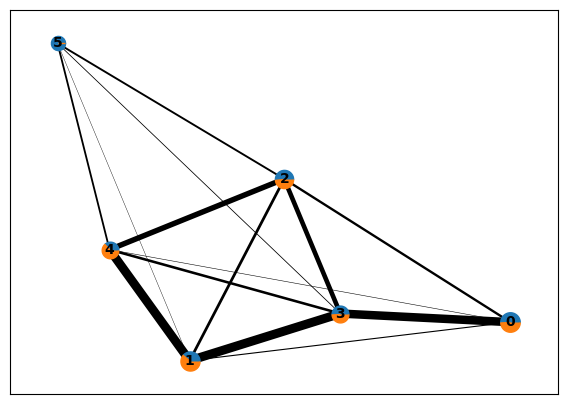

PAGA connectivity matrix:
[[0.         0.10591326 0.22592046 0.81403356 0.05093883 0.00998438]
 [0.10591326 0.         0.26464968 0.85774634 0.84754595 0.03770417]
 [0.22592046 0.26464968 0.         0.44274101 0.52509857 0.18251702]
 [0.81403356 0.85774634 0.44274101 0.         0.24828564 0.07630607]
 [0.05093883 0.84754595 0.52509857 0.24828564 0.         0.17530446]
 [0.00998438 0.03770417 0.18251702 0.07630607 0.17530446 0.        ]]


In [28]:
sc.pl.paga(im_cells, color='condition')
print("PAGA connectivity matrix:")
print(im_cells.uns['paga']['connectivities'].todense())

<b> IM PAGA (Partition-based graph abstraction) Interpretation: </b>

The above trajectory graph illustrates what we were able to infer from the cross tabs, but with the added information of the strength between the states, suggesting 1,3,4 are all related states or transition between those states
of these, 1 and 3 have the weakest connection to 5, the terminal state (what is likely a classical inflammatory response).
All of the nodes somehow connect to that classical state, with decent strength to other node. So far, there isn't a sign of a "dead" end, but again this is pseudotime and the cyclical connection of the middle nodes reminds us that the notion of "dead end" cannot be observed from pseudo-time states.
As planned, we continue on to differential expression and pathway analysis for each of pseudotime clusters.

### Differential Expression -> Pathway Enrichement of Pseudotime Clusters:

In [36]:
# First, make sure you have the leiden 1.0 clustering
sc.tl.leiden(im_cells, resolution=1.0, key_added='leiden_1.0')

# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.0',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.0_markers'
)

/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py

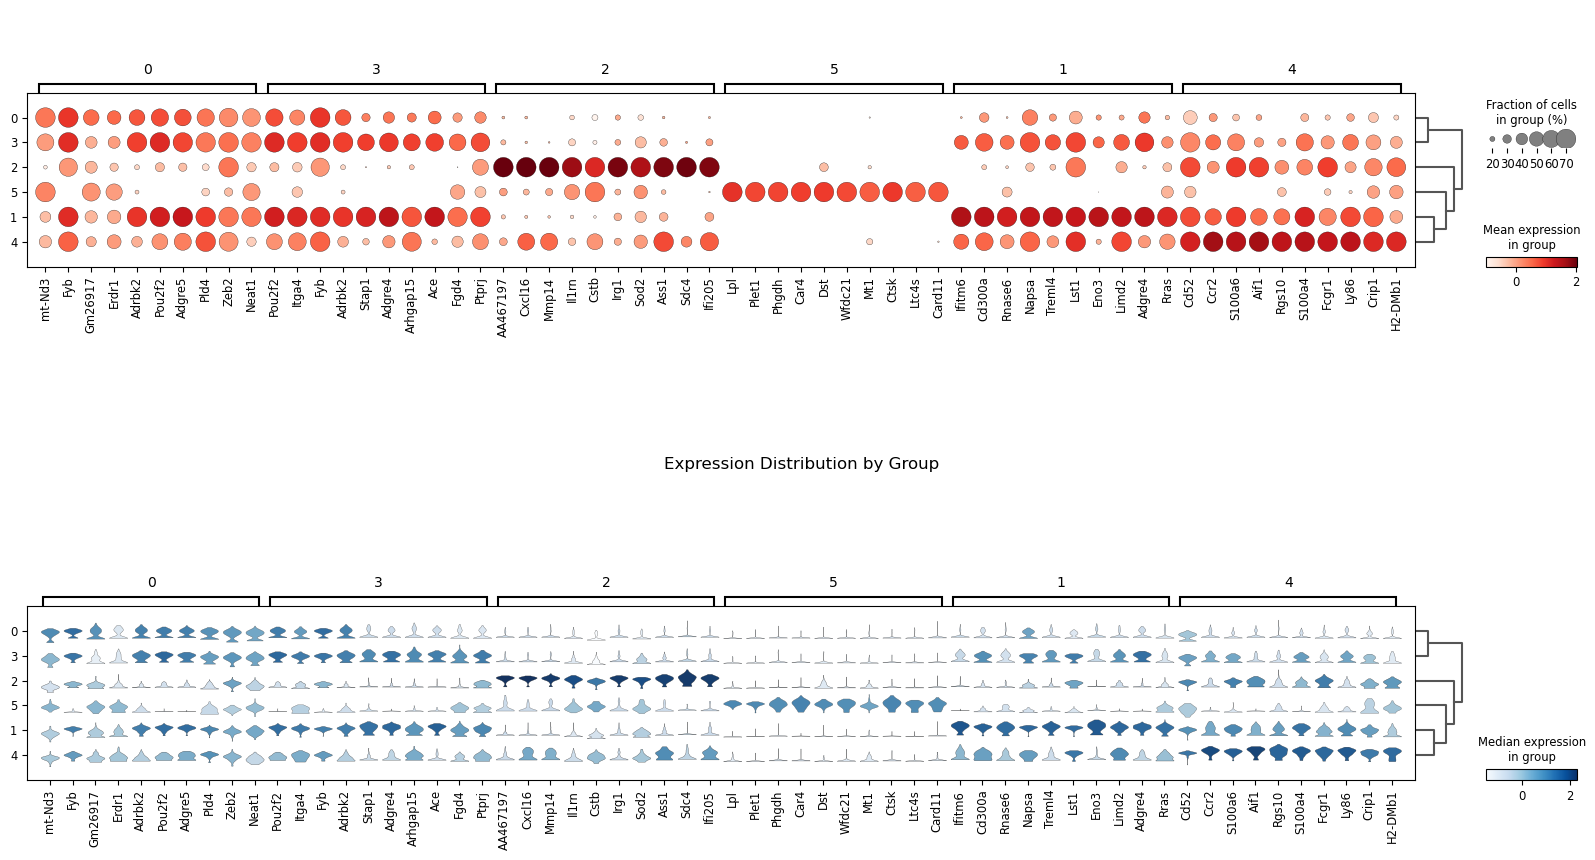

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10))

# Plot without showing, then remove default titles
sc.pl.rank_genes_groups_dotplot(im_cells, n_genes=10, key='leiden_1.0_markers',
                               dot_max=0.7, dot_min=0.1, 
                               ax=ax1, show=False)
ax1.set_title('')  # Remove default title
ax1.text(0.5, 0.5, 'Mean Expression by Group', transform=ax1.transAxes, 
         ha='center', va='bottom', fontsize=12)

sc.pl.rank_genes_groups_stacked_violin(im_cells, n_genes=10, key='leiden_1.0_markers',
                                      ax=ax2, show=False)
ax2.set_title('')  # Remove default title  
for text in ax2.texts:
    text.remove()
ax2.text(0.5, 1.2, 'Expression Distribution by Group', transform=ax2.transAxes,
         ha='center', va='bottom', fontsize=12)

plt.subplots_adjust(hspace=1)
plt.show()

STAT6 Genes to Look For!
Stat6 - Core transcription factor for IL-4/IL-13 signaling
Il4ra - IL-4 receptor alpha chain, upstream of STAT6
Il13ra1 - IL-13 receptor alpha 1 chain
Il13ra2 - IL-13 receptor alpha 2 chain, decoy receptor
Arg2 - Arginase 2, amino acid metabolism
Fizz1 - Found in inflammatory zone 1, extracellular matrix
Retnla - Resistin-like alpha, same as Fizz1
Chia - Chitinase acidic, chitin degradation
Chia1 - Chitinase acidic 1, alternative name for Chia
Il10 - Interleukin 10, anti-inflammatory cytokine
Ccl17 - Chemokine ligand 17, T cell recruitment
Ccl22 - Chemokine ligand 22, T cell recruitment
Il4 - Interleukin 4, activates STAT6 pathway
Il13 - Interleukin 13, activates STAT6 pathway
Jak1 - Janus kinase 1, upstream kinase in pathway
Jak3 - Janus kinase 3, upstream kinase in pathway
Socs1 - Suppressor of cytokine signaling 1, negative feedback
Socs3 - Suppressor of cytokine signaling 3, negative feedback
Key Genes Upregulated in IMs Suggesting STAT6 Activity
Arg1 (Arginase 1): Strongly upregulated in infected IMs; a canonical marker of M2 macrophage polarization and a direct STAT6 target.

Fizz1 (Retnla): Upregulated in infected IMs; another M2 marker regulated by STAT6.

Klf4: The transcription factor KLF4, which cooperates with STAT6 to drive M2 polarization, was found to be upregulated.

CD206 (Mrc1): Increased expression in infected IMs; a marker of alternative (M2) activation, often under STAT6 control.

CD163: Upregulated in infected IMs, consistent with M2-like polarization.

Il10: Elevated expression, which is associated with anti-inflammatory, M2-like states and can be downstream of STAT6 signaling.

Socs1, Socs3: These suppressors of cytokine signaling are upregulated and are known to be induced by STAT6 in the context of M2 polarization.

M2-Associated Genes: Other upregulated genes include msr1, cxcl16, egr2, il1rn, mmp14, ccr1, ccr2, clec4b, and parp14.

<b> MMP14,Cxc16 ,Il1rn ,Klf4 </b>

In [82]:
list(im_cells.obs.columns)

['original_sample_id',
 'title_x',
 'geo_accession_x',
 'status_x',
 'submission_date_x',
 'last_update_date_x',
 'type_x',
 'channel_count_x',
 'source_name_ch1_x',
 'organism_ch1_x',
 'taxid_ch1_x',
 'characteristics_ch1_x',
 'molecule_ch1_x',
 'extract_protocol_ch1_x',
 'description_x',
 'data_processing_x',
 'platform_id_x',
 'contact_name_x',
 'contact_email_x',
 'contact_laboratory_x',
 'contact_department_x',
 'contact_institute_x',
 'contact_address_x',
 'contact_city_x',
 'contact_state_x',
 'contact_zip/postal_code_x',
 'contact_country_x',
 'instrument_model_x',
 'library_selection_x',
 'library_source_x',
 'library_strategy_x',
 'relation_x',
 'supplementary_file_1_x',
 'supplementary_file_2_x',
 'series_id_x',
 'data_row_count_x',
 'title_y',
 'geo_accession_y',
 'status_y',
 'submission_date_y',
 'last_update_date_y',
 'type_y',
 'channel_count_y',
 'source_name_ch1_y',
 'organism_ch1_y',
 'taxid_ch1_y',
 'characteristics_ch1_y',
 'molecule_ch1_y',
 'extract_protocol_ch1_

In [45]:
# Extract top genes from each DE comparison
def get_top_genes(adata_obj, key, group, n_genes=20):
    """Extract top DE genes from scanpy results"""
    if key in adata_obj.uns:
        genes = adata_obj.uns[key]['names'][group][:n_genes].tolist()
        return [g for g in genes if pd.notna(g)]
    else:
        print(f"Key {key} not found")
        return []



def search_pathways(df, search_terms):
    """Search pathway results for specific terms"""
    if df.empty:
        return pd.DataFrame()
    mask = df['name'].str.contains('|'.join(search_terms), case=False, na=False)
    return df[mask][['name', 'p_value', 'source', 'intersection_size']]
            

In [132]:

stat6_terms = [
    # STAT6 Specific & Signaling
    'STAT6',
    'IL-4 signaling',
    'IL-13 signaling',
    'JAK-STAT signaling pathway',
    'STAT protein activation',
    'DNA-binding transcription factor activity',
    'sequence-specific DNA binding',
    'transcription activator activity',
    'transcription regulatory region DNA binding',
    'protein binding',
    'identical protein binding',
    'cytokine-mediated signaling pathway',

    # Macrophage Polarization & Permissiveness
    'macrophage polarization',
    'M2 macrophage',
    'alternatively activated macrophage',
    'anti-inflammatory response',
    'immune suppression',
    'immune evasion',
    'bacterial persistence',
    'intracellular bacterial survival',
    'phagosome maturation',
    'effusion clearance', # Efferocytosis is clearance of apoptotic cells
    'wound healing',
    'tissue repair',
    'resolution of inflammation',

    # Klebsiella & Infection Specifics
    'Klebsiella pneumoniae',
    'bacterial infection',
    'pathogen recognition',
    'Toll-like receptor signaling pathway',
    'type I interferon signaling pathway',
    'IL-10 signaling pathway',
    'necroptosis',

    # Immune/Inflammatory Downregulation
    'downregulation of immune response',
    'negative regulation of inflammatory response',
    'pro-inflammatory',
    'cytokine production', # Use if you expect reduced production
    'Th1 differentiation',
    'IL-17 production',
    'iNOS'

    # Upregulated genes from the study + other sources, see citations for support
    "Cxcl16", #hemokine (C-X-C motif) ligand 16 (CXCL16) productions following a cellular stimulus
    "Mmp14", # A protien complex
    "Il1rn", #Interleukin-1 receptor antagonist protein
    "Klf4" #krueppel-like transcription factor pthr23235
    "Arg1",
    "Fizz1",
    "Il10",
    "Pparγ"
]

M1_terms = [    
    "Classical activation",
    "M1 macrophage activation", 
    "NF-kappaB signaling",
    "TNF signaling",
    "Inflammatory response",
    "Response to LPS",
    "Nitric oxide biosynthesis",
    "Response to interferon-gamma",
    "IL-1 signaling",
    "Complement activation",
    "Acute inflammatory response"
]

M2_terms = [
    "Alternative activation",
    "M2 macrophage activation",
    "Wound healing",
    "Tissue repair", 
    "Extracellular matrix organization",
    "Collagen metabolism",
    "Arginine metabolism",
    "Response to IL-4",
    "Response to IL-13",
    "Anti-inflammatory response",
    "Phagocytosis"
]

immune_terms = [
    'immune response',    # Broad term
    'host defense',       # Broad term
    'antimicrobial activity', # Functional term
    'bacterial clearance',# Functional term
    'pathogen recognition',# Functional term
    'inflammation',       # General inflammatory process
    'macrophage',         # Cell type
    'neutrophil',         # Other immune cell
    'lymphocyte',         # Other immune cell
    'T cell',             # Other immune cell
    'B cell',             # Other immune cell
    'cytokine',           # General term for signaling molecules
    'chemokine',          # General term for chemoattractants
    'M1 macrophage',      # Opposite polarization state
    'proinflammatory cytokine', # Type of cytokine
    'Tnf',                # Tumor necrosis factor - Pro-inflammatory
    'Il1b',               # Interleukin 1 beta - Pro-inflammatory
    'Il6',                # Interleukin 6 - Pro-inflammatory
    'Nos2',               # Nitric Oxide Synthase 2 (iNOS) - M1 marker, nitric oxide production
    'Nlrp3',              # NOD-like receptor family pyrin domain containing 3 - Inflammasome component
    'Mhc2',               # Major Histocompatibility Complex, Class II - Antigen presentation
    'Cd80',               # CD80 - Co-stimulatory molecule
    'Cd86',               # CD86 - Co-stimulatory molecule
    'Fcgr1',              # Fc gamma Receptor I (CD64) - M1 associated
    'Itgam',              # Integrin alpha M (CD11b) - Adhesion, phagocytosis
    'Casp1',              # Caspase 1 - Key for pyroptosis and cytokine processing
    'Casp3',              # Caspase 3 - Key for apoptosis
    'pyroptosis',         # Inflammatory cell death pathway
    'apoptosis'           # Programmed cell death
]

interferon_terms = [
    'interferon response',# Broad term
    'antiviral defense',  # Functional term
    'Ifna',               # Interferon alpha (Type I IFN)
    'Ifnb1',              # Interferon beta 1 (Type I IFN)
    'Ifng',               # Interferon gamma (Type II IFN)
    'IfnLr1',             # Interferon Lambda Receptor 1 (Type III IFN receptor)
    'Isg15',              # Interferon Stimulated Gene 15 - Common ISG
    'Mx1',                # Myxovirus resistance 1 - Common ISG
    'Oas1',               # 2'-5'-Oligoadenylate synthetase 1 - Common ISG
    'Ifit1',              # Interferon induced protein with tetratricopeptide repeats 1 - Common ISG
    'Stat1',              # Signal transducer and activator of transcription 1 - Key for IFN signaling
    'Irf1',               # Interferon Regulatory Factor 1 - Transcription factor
    'Irf3',               # Interferon Regulatory Factor 3 - Transcription factor
    'Irf7',               # Interferon Regulatory Factor 7 - Transcription factor
    'Irf9',               # Interferon Regulatory Factor 9 - Transcription factor
    'Ifngr1',             # Interferon gamma receptor 1
    'Ifnar1'              # Interferon alpha/beta receptor 1
]

terms_lists = [stat6_terms, M1_pathways, M2_pathways, immune_terms, interferon_terms]

In [139]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = ['0', '1', '2', '3', '4', '5']
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.0_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
       
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 0 ---
Top genes (n=20): ['mt-Nd3', 'Fyb', 'Gm26917', 'Erdr1', 'Adrbk2', 'Pou2f2', 'Adgre5', 'Pld4', 'Zeb2', 'Neat1', 'Nr4a1', 'Rsrp1', 'Ccnl1', 'Ace', 'Zfyve9', 'Abi3', 'Myo1g', 'Hmha1', 'Dusp1', 'Mir17hg']
STAT6-related pathways: 0 found
M1 pathways: 0 found
M2 pathways: 0 found
Immune pathways: 0 found
Interferon pathways: 0 found

--- Cluster 1 ---
Top genes (n=20): ['Ifitm6', 'Cd300a', 'Rnase6', 'Napsa', 'Treml4', 'Lst1', 'Eno3', 'Limd2', 'Adgre4', 'Rras', 'Clec4a1', 'Hfe', 'Ifitm2', 'Pglyrp1', 'Klf2', 'Cd300ld', 'Lyl1', 'Ace', 'Spn', 'Ssh2']
STAT6-related pathways: 2 found
                                 name   p_value source  intersection_size
14  regulation of cytokine production  0.024515  GO:BP                  6
15                cytokine production  0.025629  GO:BP                  6
M1 pathways: 0 found
M2 pathways: 0 found
Immune pathways: 5 found
                                            name   p_val

### We found STAT6 related pathways!

<b> Cluster 2 shows stronger STAT6 pathway activity because: </b>

- Cluster 2's top DE genes include three STAT6-associated genes (Cxcl16, Mmp14, Il1rn) that are directly upregulated by STAT6 signaling and highlighted in the referenced paper as markers of alternative (M2-like) macrophage activation. This is direct gene-level evidence of STAT6 pathway engagement in this cluster.

- Cluster 2's pathway enrichment includes a STAT6-relevant term (“positive regulation of cytokine production”) and multiple immune pathways, which aligns with the known biology of STAT6-driven macrophage states.

<b> Cluster 1, by contrast: </b>

- Does not contain any of the main STAT6-associated genes among its top DE genes, even though it has two enriched pathways related to cytokine production. These pathways are broad and can be driven by many signaling programs, not just STAT6.

- The pathway terms in Cluster 1 (“regulation of cytokine production” and “cytokine production”) are general and not specific to STAT6 or alternative activation.

<b> Why gene-level evidence matters: </b>
Pathway enrichment is a statistical approach that identifies overrepresented biological themes, but the presence of direct STAT6 targets among the most upregulated genes in Cluster 2 provides more specific and robust evidence that STAT6 signaling is actively shaping the transcriptional profile of that cluster. In contrast, pathway hits in Cluster 1 could arise from other cytokine signaling pathways or general immune activation, not necessarily STAT6-driven processes.

Combining gene-level and pathway-level evidence is stronger than pathway enrichment alone—especially when pathway terms are broad. This is why Cluster 2 stands out as the more definitive STAT6/M2-like cluster in your data.


### Not done yet! - Ideally the signs of this pathway are from a single well-defined set, from which we can best characterize the M(KP) polarization state.

So, we increase the clustering resolution to see if one of the higher res clusters can capture all the pathway signatures (and thus exemplify the state we are validating) within a more specific macrophage subpopulation.


In [118]:
# Try multiple incremental resolutions increases from 1.0 on IM cells
#sc.tl.leiden(im_cells, resolution=1.0, key_added='leiden_1.0') - our exising baseline
sc.tl.leiden(im_cells, resolution=1.05, key_added='leiden_1.05')
sc.tl.leiden(im_cells, resolution=1.1, key_added='leiden_1.1')
sc.tl.leiden(im_cells, resolution=1.15, key_added='leiden_1.15')
sc.tl.leiden(im_cells, resolution=1.2, key_added='leiden_1.2')
sc.tl.leiden(im_cells, resolution=1.25, key_added='leiden_1.25')

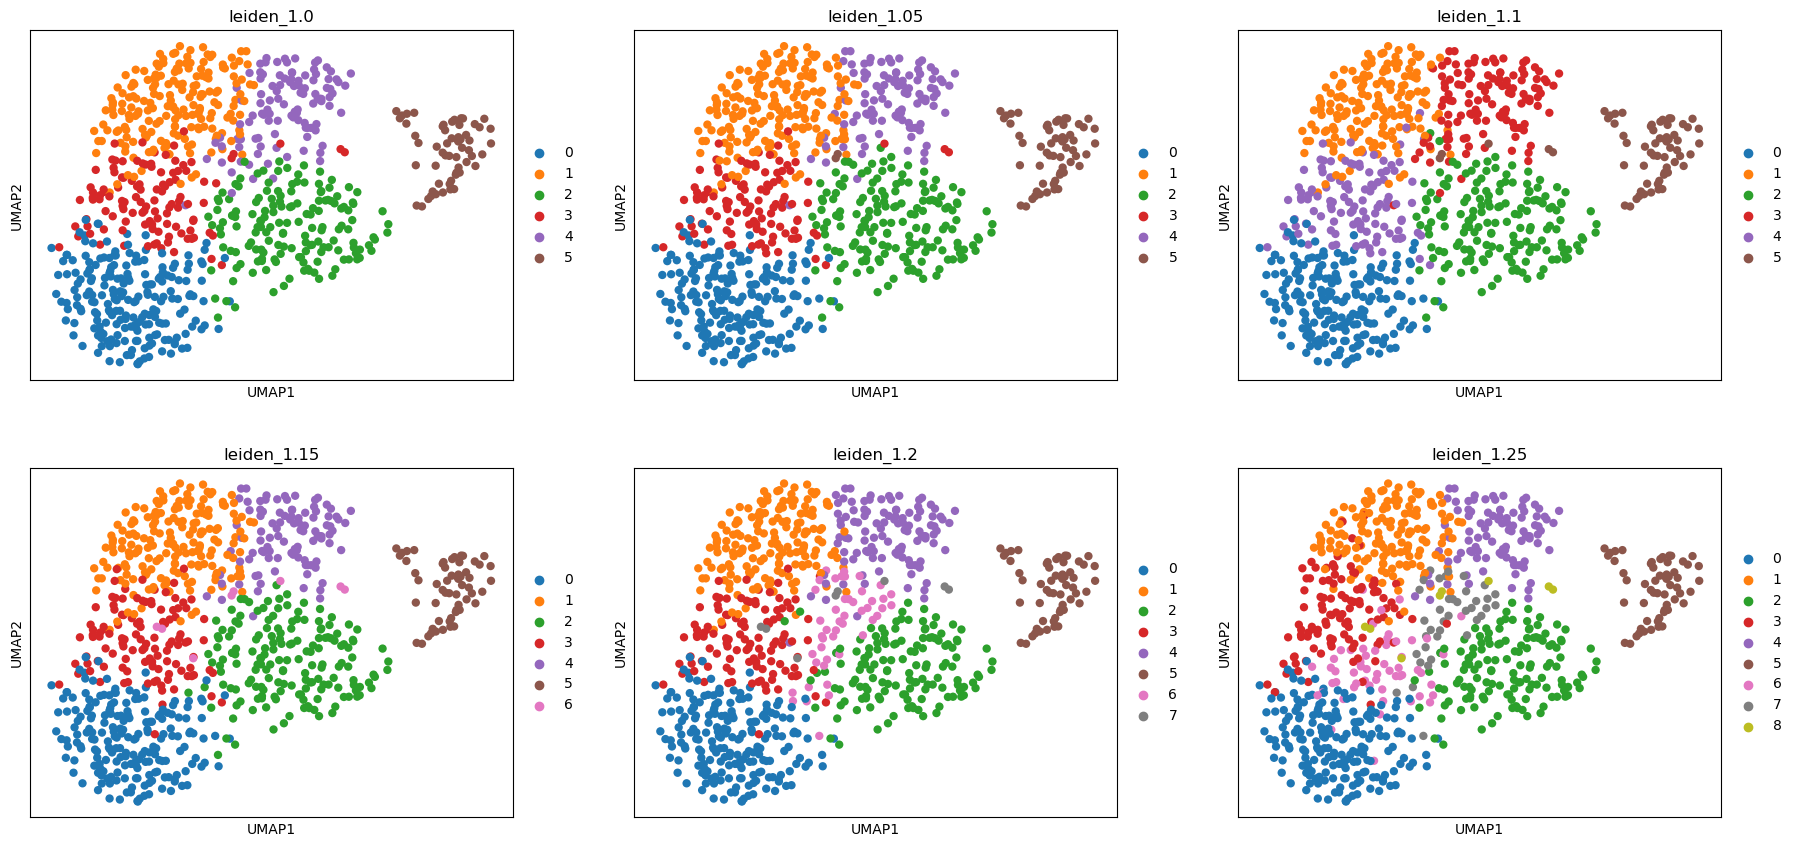

In [119]:
sc.pl.umap(im_cells, color=['leiden_1.0', 'leiden_1.05', 'leiden_1.1', 'leiden_1.15','leiden_1.2','leiden_1.25'], ncols=3)

In [103]:
for res in ['1.0', '1.05', '1.1', '1.15', '1.2', '1.25']:
    print(f"\n=== IM Resolution {res} ===")
    crosstab = pd.crosstab(im_cells.obs[f'leiden_{res}'], im_cells.obs['condition'])
    print(crosstab)


=== IM Resolution 1.0 ===
condition   KP+  KP-
leiden_1.0          
0           104  101
1            74  116
2            81   76
3            58   56
4            40   68
5            58    0

=== IM Resolution 1.05 ===
condition    KP+  KP-
leiden_1.05          
0            103   99
1             74  117
2             84   81
3             55   57
4             39   63
5             60    0

=== IM Resolution 1.1 ===
condition   KP+  KP-
leiden_1.1          
0           102   99
1            67  100
2            84   81
3            45   77
4            54   60
5            63    0

=== IM Resolution 1.15 ===
condition    KP+  KP-
leiden_1.15          
0            100   98
1             71  115
2             85   82
3             56   58
4             38   63
5             58    0
6              7    1

=== IM Resolution 1.2 ===
condition   KP+  KP-
leiden_1.2          
0            98   97
1            67  101
2            70   66
3            52   58
4            38   72
5     

#### 1.05 RES

In [104]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.05',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.05_markers'
)

/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py

In [145]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = im_cells.obs['leiden_1.05'].unique().tolist()
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.05_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 1 ---
Top genes (n=20): ['Ifitm6', 'Cd300a', 'Rnase6', 'Napsa', 'Eno3', 'Treml4', 'Limd2', 'Lst1', 'Adgre4', 'Clec4a1', 'Ifitm2', 'Rras', 'Hfe', 'Pglyrp1', 'Ace', 'Cd300ld', 'Spn', 'Ssh2', 'Lyl1', 'Klf2']
STAT6-related pathways: 2 found
                                 name   p_value source  intersection_size
14  regulation of cytokine production  0.024515  GO:BP                  6
15                cytokine production  0.025629  GO:BP                  6
M1 pathways: 0 found
M2 pathways: 0 found
Immune pathways: 5 found
                                            name   p_value source  \
1                                immune response  0.000856  GO:BP   
8   negative regulation of lymphocyte activation  0.009663  GO:BP   
14             regulation of cytokine production  0.024515  GO:BP   
15                           cytokine production  0.025629  GO:BP   
20                         lymphocyte activation  0.041106 

#### 1.1 RES

In [106]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.1',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.1_markers'
)

/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py

In [146]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = im_cells.obs['leiden_1.1'].unique().tolist()
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.1_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 1 ---
Top genes (n=20): ['Ifitm6', 'Rnase6', 'Eno3', 'Cd300a', 'Napsa', 'Pglyrp1', 'Hfe', 'Treml4', 'Adgre4', 'Spn', 'Rras', 'Limd2', 'Ace', 'Clec4a1', 'Cd300ld', 'Lyl1', 'Ifitm2', 'Cd300e', 'Lst1', 'Ssh2']
STAT6-related pathways: 0 found
M1 pathways: 0 found
M2 pathways: 0 found
Immune pathways: 3 found
                                            name   p_value source  \
2                                immune response  0.000856  GO:BP   
8   negative regulation of lymphocyte activation  0.009663  GO:BP   
18                         lymphocyte activation  0.041106  GO:BP   

    intersection_size  
2                  10  
8                   4  
18                  6  
Interferon pathways: 0 found

--- Cluster 0 ---
Top genes (n=20): ['mt-Nd3', 'Fyb', 'Gm26917', 'Erdr1', 'Pou2f2', 'Adrbk2', 'Pld4', 'Adgre5', 'Zeb2', 'Neat1', 'Nr4a1', 'Rsrp1', 'Ccnl1', 'Ace', 'Zfyve9', 'Myo1g', 'Abi3', 'Hmha1', 'Hes1', 'Mir17hg']
STA

#### 1.15 RES

In [108]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.15',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.15_markers'
)

/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py

In [142]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = im_cells.obs['leiden_1.15'].unique().tolist()
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.15_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 1 ---
Top genes (n=20): ['Ifitm6', 'Cd300a', 'Napsa', 'Rnase6', 'Treml4', 'Eno3', 'Limd2', 'Adgre4', 'Lst1', 'Rras', 'Clec4a1', 'Ifitm2', 'Hfe', 'Pglyrp1', 'Ace', 'Cd300ld', 'Klf2', 'Spn', 'Lyl1', 'Metrnl']
STAT6-related pathways: 2 found
                                 name   p_value source  intersection_size
15  regulation of cytokine production  0.024515  GO:BP                  6
16                cytokine production  0.025629  GO:BP                  6
M1 pathways: 0 found
M2 pathways: 0 found
Immune pathways: 5 found
                                            name   p_value source  \
2                                immune response  0.000856  GO:BP   
9   negative regulation of lymphocyte activation  0.009663  GO:BP   
15             regulation of cytokine production  0.024515  GO:BP   
16                           cytokine production  0.025629  GO:BP   
21                         lymphocyte activation  0.04110

#### 1.2 RES

In [110]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.2',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.2_markers'
)

/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py

In [143]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = im_cells.obs['leiden_1.2'].unique().tolist()
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.2_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 1 ---
Top genes (n=20): ['Eno3', 'Ifitm6', 'Napsa', 'Rnase6', 'Cd300a', 'Treml4', 'Pglyrp1', 'Hfe', 'Adgre4', 'Rras', 'Limd2', 'Spn', 'Ace', 'Lst1', 'Cd300ld', 'Lyl1', 'Clec4a1', 'Ceacam1', 'Cd300e', 'Ifitm2']
STAT6-related pathways: 2 found
                                 name   p_value source  intersection_size
32  regulation of cytokine production  0.024515  GO:BP                  6
33                cytokine production  0.025629  GO:BP                  6
M1 pathways: 0 found
M2 pathways: 0 found
Immune pathways: 14 found
                                               name   p_value source  \
2                                   immune response  0.000063  GO:BP   
4      negative regulation of lymphocyte activation  0.000190  GO:BP   
11  negative regulation of T cell mediated immunity  0.000986  GO:BP   
15                            lymphocyte activation  0.002682  GO:BP   
22                         T cell medi

#### 1.25 RES

In [112]:
# Run differential expression for each cluster vs all others
sc.tl.rank_genes_groups(
    im_cells,
    groupby='leiden_1.25',
    reference='rest',  # Each cluster vs all other clusters
    method='wilcoxon',
    key_added='leiden_1.25_markers'
)

/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/brian/miniconda3/envs/celltypist_stable_env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py

In [144]:
 # Now run pathway analysis for each cluster
 print("=== Analyzing pathway enrichment for each IM cluster ===")
 # Focus on clusters that might contain M(KP) signature
 target_clusters = im_cells.obs['leiden_1.25'].unique().tolist()
 for cluster in target_clusters:
     print(f"\n--- Cluster {cluster} ---")
     # Get top genes for this cluster
     cluster_genes = get_top_genes(im_cells, 'leiden_1.25_markers', cluster, 20)
     print(f"Top genes (n={len(cluster_genes)}): {cluster_genes}")
     if len(cluster_genes) > 0:
         # Run pathway enrichment
         pathways = gp.profile(
             organism=organism_id,
             query=cluster_genes,
             sources=['GO:BP',  # Biological Process (crucial for immune responses, polarization)
                      'GO:MF',  # Molecular Function (for STAT6 activity, enzyme function)
                      'KEGG',   # Canonical pathways, often includes infection and signaling
                      'REAC',   # Reactome pathways (detailed human pathways)
                      'WP',     # WikiPathways (community curated, potentially specific)
                      'TF',
                      'HP'],
             user_threshold=0.05
         )
         # Search for STAT6 pathways
         stat6_results = search_pathways(pathways, stat6_terms)
         print(f"STAT6-related pathways: {len(stat6_results)} found")
         if not stat6_results.empty:
             print(stat6_results.head())
        # Search for M1 polarization pathways
         M1_results = search_pathways(pathways, M1_terms)
         print(f"M1 pathways: {len(M1_results)} found")
         if not M1_results.empty:
             print(M1_results.head())
        # Search for M2 polarization pathways
         M2_results = search_pathways(pathways, M2_terms)
         print(f"M2 pathways: {len(M2_results)} found")
         if not M2_results.empty:
             print(M2_results.head())
         # Search for immune pathways
         immune_results = search_pathways(pathways, immune_terms)
         print(f"Immune pathways: {len(immune_results)} found")
         if not immune_results.empty:
             print(immune_results.head())
         # Search for interferon pathways
         ifn_results = search_pathways(pathways, interferon_terms)
         print(f"Interferon pathways: {len(ifn_results)} found")
         if not ifn_results.empty:
             print(ifn_results.head())
     else:
         print("No genes found for this cluster")

=== Analyzing pathway enrichment for each IM cluster ===

--- Cluster 3 ---
Top genes (n=20): ['Pou2f2', 'Adrbk2', 'Ace', 'Adgre4', 'Stap1', 'Itga4', 'Treml4', 'Napsa', 'Itgal', 'Fyb', 'Dusp16', 'Spn', 'Pglyrp1', 'Rnase6', 'Cd300ld', 'Myo1g', 'Cd300a', 'Stk38', 'Abi3', 'Adgre5']
STAT6-related pathways: 0 found
M1 pathways: 0 found
M2 pathways: 1 found
            name  p_value source  intersection_size
11  phagocytosis  0.01994  GO:BP                  4
Immune pathways: 3 found
                    name   p_value source  intersection_size
2       T cell migration  0.000169  GO:BP                  4
4   lymphocyte migration  0.000754  GO:BP                  4
16       immune response  0.034622  GO:BP                  8
Interferon pathways: 0 found

--- Cluster 1 ---
Top genes (n=20): ['Rnase6', 'Ifitm6', 'Lst1', 'Cd300a', 'Limd2', 'Klf2', 'Adgre4', 'Treml4', 'Rras', 'Napsa', 'Clec4a1', 'Eno3', 'Ifitm2', 'Pglyrp1', 'Ceacam1', 'Nr4a1', 'Ace', 'Hfe', 'Lyl1', 'Metrnl']
STAT6-related pathways

### After comparing the pathways picked up in each of the partition resolutions, 1.1 results in a single cluster showing 3 STAT6 pathways
Cluster 2 at a Leiden cluster resolution of 1.1 contains the signatures of 3 STAT6-related pathways and is superior to cluster 2 at 1.0 resolution as the signal was split into cluster 1 having a STAT6-related pathway.
- The cells in Cluster 2 are our best set for understanding the Klebsiella-permissive polarization state that Kleb seems to be inducing in the Interstitial Macrophage cells.
- lets look at the numbers of KP+ and KP- once more:

In [114]:
for res in ['1.1']:
    print(f"\n=== IM Resolution {res} ===")
    crosstab = pd.crosstab(im_cells.obs[f'leiden_{res}'], im_cells.obs['condition'])
    print(crosstab)


=== IM Resolution 1.1 ===
condition   KP+  KP-
leiden_1.1          
0           102   99
1            67  100
2            84   81
3            45   77
4            54   60
5            63    0


<b> M(KP) as a "shared" polarization state: The fact that cluster 2 maintains the 50/50 ratio suggests that: </b>

Infected cells can adopt M(KP) polarization instead of going straight to terminal activation
Bystander cells can be induced into M(KP) by paracrine signals from infected neighbors
M(KP) represents a stable intermediate state, not just a transition point

This perfectly aligns with the paper's findings about TLR-type I IFN-IL10-STAT6 axis (In vivo single‐cell transcriptomics reveal Klebsiella pneumoniae skews lung macrophages to promote infection - PMC) - the IL-10 and type I IFN can [act as paracrine signals affecting nearby bystander cells.]

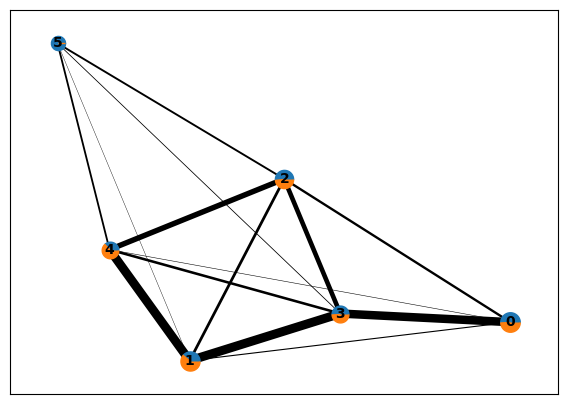

PAGA connectivity matrix:
[[0.         0.10591326 0.22592046 0.81403356 0.05093883 0.00998438]
 [0.10591326 0.         0.26464968 0.85774634 0.84754595 0.03770417]
 [0.22592046 0.26464968 0.         0.44274101 0.52509857 0.18251702]
 [0.81403356 0.85774634 0.44274101 0.         0.24828564 0.07630607]
 [0.05093883 0.84754595 0.52509857 0.24828564 0.         0.17530446]
 [0.00998438 0.03770417 0.18251702 0.07630607 0.17530446 0.        ]]


In [115]:
# Run trajectory analysis on both cell types
 # Run PAGA (no plotting parameters)
sc.tl.paga(im_cells, groups='leiden_1.0')

sc.pl.paga(im_cells, color='condition')
print("PAGA connectivity matrix:")
print(im_cells.uns['paga']['connectivities'].todense())

<h1> Validation of M(KP) as a Distinct Polarization State </h1>

Our analysis of the top differentially expressed genes in cluster 2 provides excellent validation of the M(KP) polarization state described in the original paper. The gene signature strongly supports that this cluster represents the novel STAT6-dependent macrophage polarization induced by Klebsiella pneumoniae. Key M(KP) markers are clearly present, including Isg15, which was specifically mentioned in the paper as part of the type I interferon response characteristic of M(KP), and Ifi205, another interferon-induced gene that confirms the TLR-type I IFN-IL10-STAT6 axis described by the authors.
The complete gene signature reveals a mixed inflammatory profile that distinguishes M(KP) from classical polarization states. The top genes include: Cxcl16, Mmp14, Il1rn, AA467197, Cstb, Irg1, Sod2, Ass1, Ifi205, Sdc4, Hif1a, Ptafr, Creb5, Mif, Cfb, Isg15, Cd40, Clec4e, Slamf7, and Slc2a1. This signature demonstrates M2-like characteristics through genes such as Il1rn (IL-1 receptor antagonist, anti-inflammatory) and Ass1 (argininosuccinate synthase, involved in arginine metabolism), while maintaining inflammatory components like Cd40 (immune activation marker) and Irg1 (immunoresponsive gene 1). The presence of metabolic reprogramming genes including Hif1a (hypoxia response), Ass1, and Slc2a1 (glucose transporter) further supports the unique metabolic signature of M(KP) cells.
Importantly, cluster 2 showed no enrichment for classical M1 or M2 pathways in our pathway analysis, despite showing clear STAT6 pathway signatures. This absence of traditional polarization pathways actually provides even stronger validation for M(KP) as a distinct state. If cluster 2 had enriched for classical M1/M2 pathways, it would suggest that M(KP) represents merely a variant of conventional polarization rather than a truly novel state. Instead, the combination of STAT6 pathway activation, type I interferon response genes, and the absence of classical M1/M2 pathway enrichment perfectly matches the paper's description of M(KP) as a "singular M2-type" polarization that hijacks the TLR-type I IFN-IL10-STAT6 axis to create a unique immunological state distinct from conventional macrophage polarization programs.